**классификатор текстов LSTM на Keras+TensorFlow**

Евгений Борисов <borisov.e@solarl.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm

In [2]:
tqdm.pandas()

In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [4]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [5]:
data = pd.read_csv('../data/twit/positive.csv.gz',sep=';',header=None)
data.columns = ff
ppr(data)
data.sample(3)

записей: 114 911


,id,tdate,tmane,ttext,ttype,trep,tfav,tstcount,tfol,tfrien,listcount,unk
111417,411201915981402112,1386873151,katia_saccc,"RT @super__telka: И как на истории угорали, и альфия нам дафига двоек ставила:D",1,0,1,0,5118,46,39,0
51550,410046757339693056,1386597739,dvk_a,"RT @_Nastya_Foster: Приезжала домой,вернули с Дашкой традицию готовить вместе:*",1,0,1,0,8328,855,536,4
59458,410139462178725889,1386619842,White_Cat_23,RT @NKazanceva: ураааа сегодня ужеее год как я с Кирюшей:******* http://t.co/Q2tNtzxgrw,1,0,1,0,1,0,16,0


In [6]:
data = data[['id','ttext']]
data.sample(3)

,id,ttext
58502,410131885554409472,@Satirka я просто разлюбила этот праздник. И все остальные. Так проще:)
73873,410626980556468224,Наконец-то вспомнила пароль от твиттера!!!Ну привеееет)
44032,409972189996134401,"Пришло время фоток с Елками+огоньки)))ну давайте, я жду!)"


In [7]:
assert len(data['id']) == len(set(data['id']))

In [8]:
# data.dtypes

## очистка данных

In [9]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 114911/114911 [00:01<00:00, 78422.08it/s]


In [10]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [11]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 114911/114911 [00:01<00:00, 62227.08it/s]


In [12]:
data.sample(3)

,id,ttext,ttext_clean
31054,409650117168611328,"RT @YanochkaTsar: Хахахах) Резюлька зашла на пять сек забрать чехол, протрындели час:D #типичные_бабы","[rt, yanochkatsar, хахахах, резюлька, зашла, на, пять, сек, забрать, чехол, протрындели, час, happysmile, типичные, бабы]"
30634,409644580767019008,"офигенно выспалась#пол дня проспала,@Kirill_Korn ты проснулся?)","[офигенно, выспалась, пол, дня, проспала, kirill, korn, ты, проснулся]"
38657,409887691279728640,"@sugarsugar_mmm с возрастом всё чаще понимаешь, при наличии альтернатив, всё равно всегда лучшим выбором была бы водка. Умеренно конечно же)","[sugarsugar, mmm, с, возрастом, всё, чаще, понимаешь, при, наличии, альтернатив, всё, равно, всегда, лучшим, выбором, была, бы, водка, умеренно, конечно, же]"


In [13]:
# удаление коротких слов
# data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

In [14]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 114 911
записей: 114 911


In [15]:
data.sample(3)

,id,ttext,ttext_clean
29706,409630116617011200,@KseniaKozchenko #последнийкруг\nя бы ей отдала последний круг! предательство не прощается!хотя к черту её))) пусть потом не удивляется;),"[kseniakozchenko, последнийкруг, я, бы, ей, отдала, последний, круг, предательство, не, прощается, хотя, к, черту, её, happysmile, пусть, потом, не, удивляется, happysmile]"
64241,410357065459458048,RT @mekazopyjaf: для тех кто в теме: не забудьте поздравить тимура),"[rt, mekazopyjaf, для, тех, кто, в, теме, не, забудьте, поздравить, тимура]"
68388,410401416008982528,RT @Shelepova19: @despair_dd эта женщина решила свести меня с Кан Гэри :DD,"[rt, despair, dd, эта, женщина, решила, свести, меня, с, кан, гэри, happysmile, d]"


In [16]:
words = sorted(set.union( *data['ttext_clean'].apply(set) ))
voc = { w:i+1 for i,w in enumerate(words) }
voc['<pad>']= 0
ppr(voc)

записей: 166 099


In [17]:
# voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
# voc = { w:i+1 for i,w in enumerate(voc) }
# voc['<pad>']= 0
# ppr(voc)

In [18]:
# voc

## кодируем слова

In [19]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 114911/114911 [00:00<00:00, 166425.99it/s]


In [20]:
data[['ttext','ttext_clean','code']].sample(3)

,ttext,ttext_clean,code
90991,"И кстати мне нужен pr-щик. Есть кто? Также с радостью услышу рекомендации, кого советуете схантить :)","[и, кстати, мне, нужен, pr, щик, есть, кто, также, с, радостью, услышу, рекомендации, кого, советуете, схантить, happysmile]","[79635, 89090, 96611, 104886, 32158, 163176, 72882, 89131, 146295, 134675, 129850, 153603, 132594, 85638, 140592, 145328, 14801]"
39279,"@EmilyHolden_ ихих, теперь кажется все пучком и будет)\nспасибо","[emilyholden, ихих, теперь, кажется, все, пучком, и, будет, спасибо]","[11165, 82175, 147655, 82609, 60484, 129101, 79635, 54799, 142093]"
67421,"@marself526645 ахах спасибо\nОпять же, каких шедевров не вытворишь со скуки :D","[ахах, спасибо, опять, же, каких, шедевров, не, вытворишь, со, скуки, happysmile]","[49482, 142093, 108770, 73318, 82814, 161878, 101792, 62720, 140293, 138686, 14801]"


In [21]:
# оценка размеров последовательнистей
data['code'].str.len().describe().astype(int)

count    114911
mean         13
std           4
min           1
25%          10
50%          13
75%          17
max          42
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

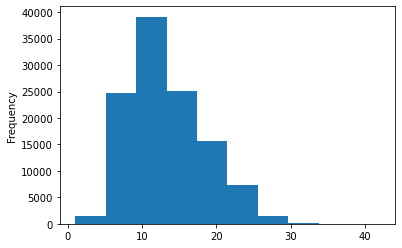

In [22]:
data['code'].str.len().plot.hist()

In [23]:
# максимальная длина
code_max_len = data['code'].str.len().max()
code_max_len

42

In [24]:
# дополняем короткие до максимальной длины
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 114911/114911 [00:00<00:00, 246142.52it/s]


In [25]:
data['code'].str.len().describe().astype(int)

count    114911
mean         42
std           0
min          42
25%          42
50%          42
75%          42
max          42
Name: code, dtype: int64

## строим датасет

In [26]:
# pair = data[['id','id']]
# pair.columns = ['id_l','id_r']
# pair

In [27]:
pair_neg = pd.DataFrame({
'id_L':data['id'].iloc[:-1].tolist(),
'id_R':data['id'].iloc[1:].tolist()
})

In [28]:
# НЕпохожие пары
pair_neg = pair_neg\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )

pair_neg['target'] = 0
ppr(pair_neg)

записей: 114 910


In [29]:
pair_pos = pd.DataFrame({
'id_L':data['id'].tolist(),
'id_R':data['id'].tolist()
})

In [30]:
# похожие пары
pair_pos = pair_pos\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )

pair_pos['target'] = 1
ppr(pair_pos)

записей: 114 911


In [31]:
cols = ['code_L','code_R','target']
dataset = pd.concat([
        pair_pos[cols],
        pair_neg[cols],
    ],axis=0).reset_index(drop=True)
ppr(dataset)

записей: 229 821


In [32]:
x_left  = np.vstack(dataset['code_L'].values)
x_right = np.vstack(dataset['code_R'].values)
target  = np.vstack(dataset['target'].values)

x_left.shape,x_right.shape,target.shape

((229821, 42), (229821, 42), (229821, 1))

In [33]:
# размер вектора OHE для embeding слоя
embed_input_dim = max([x_left.max(),x_right.max()]) + 1

In [34]:
x_left.shape, x_right.shape, target.shape, embed_input_dim

((229821, 42), (229821, 42), (229821, 1), 166099)

In [35]:
# переворачиваем последовательности (нули дополнения вначале, первое слово в конце)
x_left  = np.flip( x_left,  axis=1 )
x_right = np.flip( x_right, axis=1 )

In [36]:
# длина последовательности слов 
seq_len = x_left.shape[1]
seq_len

42

In [37]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [38]:
# отделяем тестовый набор
x_train, x_test, y_train, y_test = train_test_split( np.hstack([x_left,x_right]), target, test_size=.5)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((114910, 84), (114910, 1), (114911, 84), (114911, 1))

In [39]:
x_left_train, x_right_train = x_train[:,:seq_len],x_train[:,seq_len:]
y_train = y_train.flatten()
x_left_train.shape, x_right_train.shape, y_train.shape

((114910, 42), (114910, 42), (114910,))

In [40]:
x_left_test, x_right_test = x_test[:,:seq_len],x_test[:,seq_len:]
y_test = y_test.flatten()
x_left_test.shape, x_right_test.shape, y_test.shape

((114911, 42), (114911, 42), (114911,))

In [41]:
%xdel x_left
%xdel x_right
%xdel target

In [42]:
# gc.collect()

In [43]:
# y_train.sum()/len(y_train), y_test.sum()/len(y_test)

## модель

In [53]:
embed_len = 32
embed_input_dim, embed_len, seq_len

(166099, 32, 42)

In [54]:
from tensorflow import __version__ as tf_version
from tensorflow.keras import __version__ as keras_version
tf_version,keras_version

('2.4.1', '2.4.0')

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [56]:
# import tensorflow.keras.backend as K
# import tensorflow as tf
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [57]:
# from tensorflow_addons.losses import contrastive_loss

In [58]:
# from tensorflow.keras.losses import contrastive_loss 

In [59]:
# from tensorflow.losses import contrastive_loss

In [60]:
embed_input_dim,seq_len,embed_len

(166099, 42, 32)

In [61]:
embedding = Embedding(input_dim=embed_input_dim, input_length=seq_len, output_dim=embed_len, )

In [62]:
lstm = LSTM(embed_len,activation='relu') 

In [ ]:
# Конструирование левой ветви модели: 
input_l = Input( shape=(seq_len,), dtype='int32')
embedding_l = embedding(input_l)
lstm_l = lstm(embedding_l)

In [ ]:
# Конструирование правой ветви модели: 
input_r = Input(shape=(seq_len,), dtype='int32')
embedding_r = embedding(input_r)
lstm_r = lstm(embedding_r)

In [ ]:
# # Getting the L1 Distance between the 2 encodings
merged = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([lstm_l,lstm_r])

In [ ]:
# Добавление классификатора
predictions = Dense(1, activation='sigmoid')(merged)

In [ ]:
# Создание и обучение модели:
model = Model([input_l,input_r], predictions )

In [ ]:
plot_model(model,
           #to_file=pjoin(FOLDER_RESULT,'model-embed-lstm.png'), 
           show_layer_names=True, show_shapes=True )
# model.summary()

In [ ]:
learning_rate = 9e-5
model.compile(loss=contrastive_loss, metrics=['acc',], optimizer=Adam(learning_rate))

In [ ]:
%%time

n_epochs = 2

history = model.fit( [x_left_train, x_right_train], y_train,
           epochs = n_epochs,
           batch_size = 4096,
           validation_split=.2,
         )

In [ ]:
with open( pjoin(FOLDER_RESULT,'model-embed-lstm.json'), 'wt') as f: f.write( model.to_json() )
model.save_weights( pjoin(FOLDER_RESULT,'model-embed-lstm-weights-%02d.h5'%(n_epochs) )) 

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import TensorBoard

#            callbacks=[
# #                        EarlyStopping(monitor='acc',baseline=.98, patience=2,), # restore_best_weights=True),
#                        TensorBoard(log_dir='./logs'),
#                      ],

----

In [ ]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()

In [ ]:
plt.plot( np.array(history.history['acc']), label='train acc')
plt.plot( np.array(history.history['val_acc']), label='val acc')
plt.legend()
plt.grid()

In [ ]:
gc.collect()

## тест

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report

In [ ]:
def roc_auc_plot(y,p):
    fpr, tpr, thresholds = roc_curve( y, p )
    roc_auc = auc(fpr,tpr)

    plt.figure()
    plt.grid(True)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

---

In [ ]:
%%time 

p_train = model.predict([x_left_train, x_right_train])
accuracy_score( y_train, (p_train<.6) )

In [ ]:
pd.DataFrame(p_train).describe().T

In [ ]:
roc_auc_plot(y_train, 1.-p_train)

---

In [ ]:
%%time 

p_test = model.predict([x_left_test, x_right_test])
accuracy_score( y_test, (p_test<.6) )

In [ ]:
pd.DataFrame(p_test).describe().T

In [ ]:
roc_auc_plot(y_test, 1.-p_test)